# DL based auto-segmentation of Cornea and Lens

This code is an exact replica of the optimal procedure as reported by Andrés Ruiz-Calvo et al. in *"Automatic segmentation and quantification of OCT images before and after cataract surgery using deep learning"*.

It implements a deep learning pipeline for semantic segmentation of corneal and lens structures in grayscale OCT (Optical Coherence Tomography) images. The code performs the following tasks:

1. 📂 Loads and preprocesses OCT images and their corresponding grayscale masks:
    - Ground truth masks are mapped to 3 classes: background (0), cornea (1), lens/IOL (2).
    - Images are converted to 3-channel format (Gray scale --> RGB) to fit a pretrained ResNet-based encoder.
    - Non-divisible image sizes are padded to fit FPN network constraints (ResNet 32, devision by 32).

2. 🧠 Builds a U-Net-style Feature Pyramid Network (FPN) using a ResNet-34 encoder, pretrained on ImageNet, and applies focal loss for imbalanced data segmentation.

3. 🏋️ Trains the model using 121 images and masks (excellent, good, average and bad quality images) 80% of the dataset and validates on the remaining 20%.
    - Tracks loss for each epoch and visualizes the learning curves.
    - Automatically saves the trained weights at the end (model save).
    - Compares the guess vs grount thruth visually for training and test data.

4. 🔬 Evaluates the model using Intersection over Union (IoU) scores for each class:
    - Computes class-wise IoU for cornea and lens for training and validation data.
    - Identifies and visualizes the 3 best and worst predictions for both training and validation data.
    - Visual overlays show original image, ground truth mask, and predicted segmentation using vivid colors.

5. 🎨 Code included to validate the model on totally new data when aquired!

This code enables automated evaluation of cornea and lens regions in OCT scans and serves
as a reproducible baseline for further improvements in segmentation-based cataract research.

In [1]:
# Import Libraries:
import os
import cv2
import time
import torch
import shutil
import numpy as np
import pandas as pd
from PIL import Image
from glob import glob
from tqdm import tqdm
from pathlib import Path
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Subset
import matplotlib.patches as mpatches
from numpy.polynomial import Polynomial
from sklearn.metrics import jaccard_score
import segmentation_models_pytorch as smp
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from scipy.ndimage import label, binary_dilation
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from torch.utils.data import Dataset, DataLoader, random_split

### 1. 📂 Loads and preprocesses OCT images and their corresponding grayscale masks:

In [2]:
# Create basic class structure for OCT data for training, and masks for lables: 
class OCTFolderDataset(Dataset):
    def __init__(self, image_dir, mask_dir=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = sorted(os.listdir(image_dir))

        if mask_dir is not None:
            self.mask_filenames = sorted(os.listdir(mask_dir))
        else:
            self.mask_filenames = None

    def __len__(self):
        return len(self.image_filenames)

    def pad_to_32(self, tensor):
        h, w = tensor.shape[-2:]
        new_h = ((h + 31) // 32) * 32
        new_w = ((w + 31) // 32) * 32
        pad_h = new_h - h
        pad_w = new_w - w
        return torch.nn.functional.pad(tensor, (0, pad_w, 0, pad_h))

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        image = Image.open(img_path).convert('L')
        image = np.array(image, dtype=np.float32) / 255.0
        h, w = image.shape

        image = torch.from_numpy(image).unsqueeze(0)  # 1 x H x W
        image = self.pad_to_32(image).repeat(3, 1, 1)  # Convert to 3-channel RGB

        if self.mask_filenames is not None:
            mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])
            mask = Image.open(mask_path).convert('L')
            mask = np.array(mask, dtype=np.uint8)

            class_mask = np.zeros_like(mask, dtype=np.int64)
            class_mask[(mask >= 201) & (mask <= 255)] = 1  # Cornea
            class_mask[(mask >= 80) & (mask <= 200)] = 2   # Lens

            class_mask = torch.from_numpy(class_mask)
            class_mask = self.pad_to_32(class_mask.unsqueeze(0)).squeeze(0)
            return image, class_mask, (h, w)
        else:
            return image, (h, w)

In [3]:
# Load a pretrained encoder, and buidl the FPN model:
model = smp.Unet(encoder_name="timm-efficientnet-b2", encoder_weights="imagenet", classes=3, activation=None)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss and optimiser:
loss_fn = smp.losses.FocalLoss(mode='multiclass', gamma=2.0)
optimizer = optim.Adam(model.parameters(), lr=5e-4)

C:\Users\G\AppData\Roaming\Python\Python312\site-packages\segmentation_models_pytorch\encoders\__init__.py:136: UserWarning: Error loading timm-efficientnet-b2 `imagenet` weights from Hugging Face Hub, trying loading from original url...
  warnings.warn(message, UserWarning)


In [4]:
# Example dummy paths — replace with the true dataset:
image_dir = r"C:\Users\G\Desktop\denoised_results_iterative"
mask_dir = r"C:\Users\G\Desktop\ALL MASKS"

### 2. 🧠 Builds a U-Net-style Feature Pyramid Network (FPN) using a ResNet-34 encoder, pretrained on ImageNet, and applies focal loss for imbalanced data segmentation.

In [5]:
# Initialize full dataset
full_dataset = OCTFolderDataset(image_dir, mask_dir)

# Determine split lengths (80 Train, 20 Val)
val_size = int(0.2 * len(full_dataset))
train_size = len(full_dataset) - val_size

# Perform random split
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create DataLoaders
batch_size_train = 8
batch_size_val = 4
train_loader = DataLoader(train_dataset, batch_size= batch_size_train, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size= batch_size_val, shuffle=False)

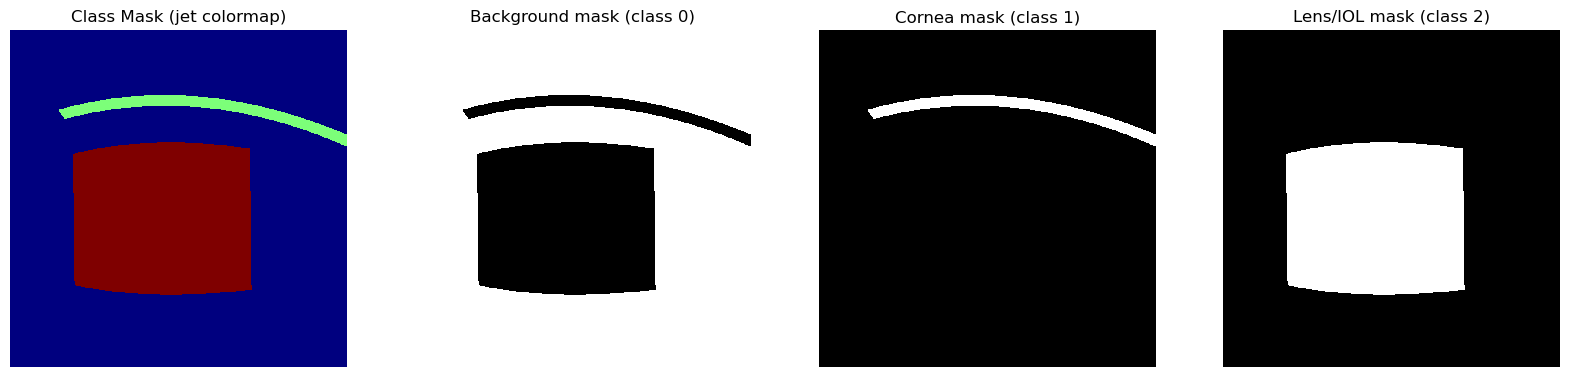

In [6]:
# Visualise the masks for verification of correcvt loading of the masks:
def visualize_mask_classes(dataset, index=None):
    """
    Show the original mask and separate class masks.
    """
    if index is None:
        index = torch.randint(len(dataset), (1,)).item()
   
    _, class_mask, _ = dataset[index]
    class_mask = class_mask.cpu().numpy()

    # Create binary masks for each class
    bg_mask = (class_mask == 0).astype(np.uint8)
    cornea_mask = (class_mask == 1).astype(np.uint8)
    lens_mask = (class_mask == 2).astype(np.uint8)

    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    axs[0].imshow(class_mask, cmap='jet', interpolation='none')
    axs[0].set_title("Class Mask (jet colormap)")
    axs[1].imshow(bg_mask, cmap='gray', interpolation='none')
    axs[1].set_title("Background mask (class 0)")
    axs[2].imshow(cornea_mask, cmap='gray', interpolation='none')
    axs[2].set_title("Cornea mask (class 1)")
    axs[3].imshow(lens_mask, cmap='gray', interpolation='none')
    axs[3].set_title("Lens/IOL mask (class 2)")
    
    for ax in axs:
        ax.axis('off')
    plt.show()

# Visualise it:
visualize_mask_classes(full_dataset, index=5)

### 🏋️ Trains the model using 121 images and masks (excellent, good, average and bad quality images) 80% of the dataset and validates on the remaining 20%.


🟣 Epoch 1/15


Training:   0%|          | 0/44 [00:00<?, ?it/s]C:\Users\G\AppData\Roaming\Python\Python312\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


✅ Epoch 1 Summary | Avg Train Loss: 0.2006 | Avg Val Loss: 0.0607 | ⏱️ Epoch Time: 774.18 sec

🟣 Epoch 2/15


✅ Epoch 2 Summary | Avg Train Loss: 0.0301 | Avg Val Loss: 0.0227 | ⏱️ Epoch Time: 779.35 sec

🟣 Epoch 3/15


✅ Epoch 3 Summary | Avg Train Loss: 0.0178 | Avg Val Loss: 0.0181 | ⏱️ Epoch Time: 766.91 sec

🟣 Epoch 4/15


✅ Epoch 4 Summary | Avg Train Loss: 0.0133 | Avg Val Loss: 0.0148 | ⏱️ Epoch Time: 766.31 sec

🟣 Epoch 5/15


✅ Epoch 5 Summary | Avg Train Loss: 0.0108 | Avg Val Loss: 0.0148 | ⏱️ Epoch Time: 766.61 sec

🟣 Epoch 6/15


✅ Epoch 6 Summary | Avg Train Loss: 0.0102 | Avg Val Loss: 0.0132 | ⏱️ Epoch Time: 767.17 sec

🟣 Epoch 7/15


✅ Epoch 7 Summary | Avg Train Loss: 0.0088 | Avg Val Loss: 0.0127 | ⏱️ Epoch Time: 762.72 sec

🟣 Epoch 8/15


✅ Epoch 8 Summary | Avg Train Loss: 0.0079 | Avg Val Loss: 0.0132 | ⏱️ Epoch Time: 763.49 sec

🟣 Epoch 9/15


✅ Epoch 9 Summary | Avg Train Loss: 0.0082 | Avg Val Loss: 0.0130 | ⏱️ Epoch Time: 765.51 sec

🟣 Epoch 10/15


✅ Epoch 10 Summary | Avg Train Loss: 0.0074 | Avg Val Loss: 0.0130 | ⏱️ Epoch Time: 1488.77 sec

🟣 Epoch 11/15


✅ Epoch 11 Summary | Avg Train Loss: 0.0065 | Avg Val Loss: 0.0132 | ⏱️ Epoch Time: 768.99 sec

🟣 Epoch 12/15


✅ Epoch 12 Summary | Avg Train Loss: 0.0061 | Avg Val Loss: 0.0131 | ⏱️ Epoch Time: 767.83 sec

🟣 Epoch 13/15


✅ Epoch 13 Summary | Avg Train Loss: 0.0055 | Avg Val Loss: 0.0138 | ⏱️ Epoch Time: 768.27 sec

🟣 Epoch 14/15


✅ Epoch 14 Summary | Avg Train Loss: 0.0054 | Avg Val Loss: 0.0132 | ⏱️ Epoch Time: 768.12 sec

🟣 Epoch 15/15


✅ Epoch 15 Summary | Avg Train Loss: 0.0053 | Avg Val Loss: 0.0133 | ⏱️ Epoch Time: 768.33 sec

⏱️ Total training time: 12242.56 seconds


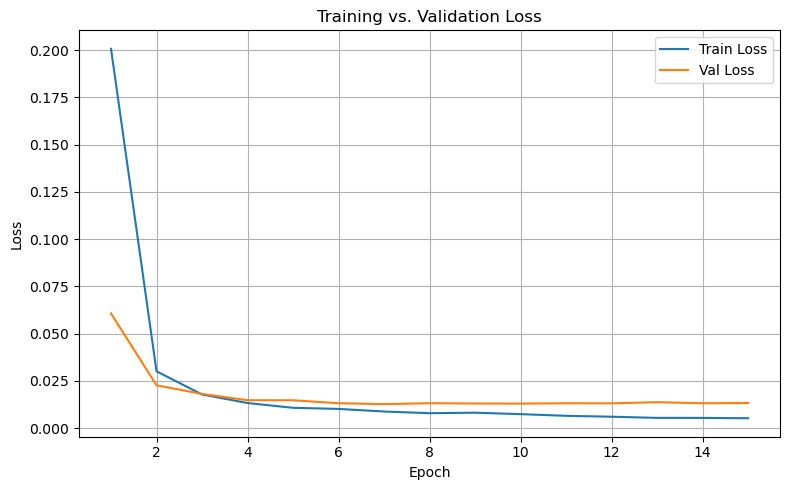

✅ Model saved to Model_ALLDATA_model_2.pth, data sets save data to train_dataset_ALLDATA_model_2.pth and val_dataset_ALLDATA_model_2.pth.


In [7]:
# Train and Validate the model:

# Initialize loss history
train_losses = []
val_losses = []

num_epochs = 15  # Adjust as needed, we find 18 epochs yields the best performance (lowes validation loss)

# Start timing total training
total_start = time.time()

for epoch in range(num_epochs):
    print(f"\n🟣 Epoch {epoch+1}/{num_epochs}")
    epoch_start = time.time()

    model.train()
    train_loss_total = 0
    train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False)

    for images, masks, _ in train_loader_tqdm:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss_total += loss.item()
        train_loader_tqdm.set_postfix(loss=loss.item())

    train_loss_avg = train_loss_total / len(train_loader)
    train_losses.append(train_loss_avg)

    # --- Validation ---
    model.eval()
    val_loss_total = 0
    val_loader_tqdm = tqdm(val_loader, desc="Validation", leave=False)

    with torch.no_grad():
        for images, masks,_ in val_loader_tqdm:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, masks)

            val_loss_total += loss.item()
            val_loader_tqdm.set_postfix(loss=loss.item())

    val_loss_avg = val_loss_total / len(val_loader)
    val_losses.append(val_loss_avg)

    epoch_time = time.time() - epoch_start
    print(f"✅ Epoch {epoch+1} Summary | Avg Train Loss: {train_loss_avg:.4f} | Avg Val Loss: {val_loss_avg:.4f} | ⏱️ Epoch Time: {epoch_time:.2f} sec")

# End timing total training
total_time = time.time() - total_start
print(f"\n⏱️ Total training time: {total_time:.2f} seconds")

# === 📈 Plotting after training ===
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save the weights of the trained model:
path_model = "Model_ALLDATA_model_2.pth"
torch.save(model.state_dict(), path_model)

# Save the datasets (only works if dataset objects are pickleable)
path_train_data = "train_dataset_ALLDATA_model_2.pth"
path_val_data = "val_dataset_ALLDATA_model_2.pth"
torch.save(train_loader.dataset, path_train_data)
torch.save(val_loader.dataset, path_val_data)

print(f"✅ Model saved to {path_model}, data sets save data to {path_train_data} and {path_val_data}.")

### 4. Load the previously trained model and the training and validation data used:

In [8]:
# Load a previosuly Trained Model (and data):
Load_original_Data =  True
Load_Model = True

# The Paths for the model and data:
path_train_data = "train_dataset_ALLDATA_model_2.pth"
path_val_data = "val_dataset_ALLDATA_model_2.pth"
path_model = "Model_ALLDATA_model_2.pth"

# Load the datasets;
if Load_original_Data:
    train_dataset = torch.load(path_train_data, weights_only=False)
    val_dataset = torch.load(path_val_data,  weights_only=False)
    print("✅ Datasets loaded successfully.")

# Rebuild the model architecture
if Load_Model:
    model = model # Or define here manually --> = smp.Unet(encoder_name="timm-efficientnet-b2", encoder_weights="imagenet", classes=3, activation=None)
    model.load_state_dict(torch.load(path_model))
    model = model.to(device)
    model.eval()
    print("✅ Model loaded successfully.")

✅ Datasets loaded successfully.
✅ Model loaded successfully.


### 5. 🎨 Code included to validate the model and or test on totally new data when aquired:

In [9]:
# Find IoU for the test and validation data, and show the best and worst 3 examples for each visually. 
def compute_iou(gt, pred, class_id):
    gt_bin = (gt == class_id).astype(np.uint8).flatten()
    pred_bin = (pred == class_id).astype(np.uint8).flatten()
    if gt_bin.sum() == 0 and pred_bin.sum() == 0:
        return 1.0
    elif gt_bin.sum() == 0 or pred_bin.sum() == 0:
        return 0.0
    return jaccard_score(gt_bin, pred_bin)

# Work With The Masked Areas:
def overlay_mask(gt, pred):
    overlay = np.zeros((gt.shape[0], gt.shape[1], 3), dtype=np.uint8)
    overlay[gt == 1] = [0, 255, 0]     # GT cornea = green
    overlay[gt == 2] = [0, 0, 255]     # GT lens = blue
    overlay[pred == 1] = [255, 255, 0] # Pred cornea = yellow
    overlay[pred == 2] = [255, 0, 255] # Pred lens = magenta
    return overlay

def extract_boundaries(mask, class_ids=(1, 2), target_shape=None, 
                      min_segment_length=10, max_gap=4):
    """
    Extract and filter boundaries - keeps only well-connected segments.
    
    Args:
        mask (np.ndarray): Input segmentation mask
        class_ids (tuple): Class IDs to extract (e.g., (1, 2))
        target_shape (tuple): Optional target shape to crop to
        min_segment_length (int): Minimum connected pixels to keep a segment
        max_gap (int): Maximum allowed gap between pixels to consider connected
        
    Returns:
        np.ndarray: Filtered boundary mask with class labels
    """
    def filter_segments(coords, h, max_gap, min_length):
        """Filter coordinate pairs to keep only well-connected segments"""
        if len(coords) == 0:
            return []
        
        # Sort by x coordinate
        coords = sorted(coords, key=lambda x: x[0])
        segments = []
        current_segment = [coords[0]]
        
        for (x, y) in coords[1:]:
            prev_x, prev_y = current_segment[-1]
            
            # Check connectivity (horizontal distance and vertical alignment)
            if (x - prev_x <= max_gap + 1) and (abs(y - prev_y) <= max_gap):
                current_segment.append((x, y))
            else:
                if len(current_segment) >= min_length:
                    segments.extend(current_segment)
                current_segment = [(x, y)]
        
        # Add last segment
        if len(current_segment) >= min_length:
            segments.extend(current_segment)
            
        return segments

    h, w = mask.shape
    boundary = np.zeros_like(mask, dtype=np.uint8)
    
    for class_id in class_ids:
        binary = (mask == class_id).astype(np.uint8)
        
        # First pass: extract all potential boundary points
        top_points = []
        bottom_points = []
        
        for x in range(w):
            y_coords = np.where(binary[:, x])[0]
            if len(y_coords) > 0:
                top_points.append((x, y_coords[0]))
                bottom_points.append((x, y_coords[-1]))
        
        # Filter segments
        filtered_top = filter_segments(top_points, h, max_gap, min_segment_length)
        filtered_bottom = filter_segments(bottom_points, h, max_gap, min_segment_length)
        
        # Mark filtered points
        for x, y in filtered_top:
            boundary[y, x] = class_id
        for x, y in filtered_bottom:
            boundary[y, x] = class_id

    if target_shape is not None:
        boundary = boundary[:target_shape[0], :target_shape[1]]
        
    return boundary

def overlay_boundaries(image_gray, boundary_mask):
    """Overlay boundary mask on grayscale image as RGB."""
    image_rgb = np.stack([image_gray]*3, axis=-1).copy()
    image_rgb[boundary_mask == 1] = [0, 255, 0]   # Green for cornea
    image_rgb[boundary_mask == 2] = [0, 0, 255]   # Blue for lens
    return image_rgb

def add_legend(ax, mode="area"):
    if mode == "area":
        legend_elements = [
            mpatches.Patch(color=(0, 1, 0), label='GT Cornea'),
            mpatches.Patch(color=(0, 0, 1), label='GT Lens'),
            mpatches.Patch(color=(1, 1, 0), label='Pred Cornea'),
            mpatches.Patch(color=(1, 0, 1), label='Pred Lens'),
        ]
    elif mode == "boundary":
        legend_elements = [
            mpatches.Patch(color=(0, 1, 0), label='Cornea Boundary'),
            mpatches.Patch(color=(0, 0, 1), label='Lens Boundary'),
        ]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=10, frameon=True)

In [10]:
def evaluate_subset(dataset, title_prefix, maskless=False, requested_indices=None):
    """
    Evaluate and visualize results from a dataset.
    
    Args:
        dataset: The dataset to evaluate
        title_prefix: Title prefix for plots
        maskless: Whether working with maskless data
        requested_indices: Optional list of specific indices to show.
                           If None, shows best/worst (default behavior).
    """
    model.eval()
    results = []

    # Process all samples
    for i in range(len(dataset)):
        data_item = dataset[i]

        if not maskless:
            img_tensor, gt_tensor = data_item[:2]
        else:
            img_tensor = data_item[0]
            gt_tensor = None

        with torch.no_grad():
            pred_tensor = model(img_tensor.unsqueeze(0).to(device))
        pred_mask = torch.argmax(pred_tensor.squeeze(), dim=0).cpu().numpy()

        if not maskless:
            gt_mask = gt_tensor.numpy()
            iou_cornea = compute_iou(gt_mask, pred_mask, 1)
            iou_lens = compute_iou(gt_mask, pred_mask, 2)
            mean_iou = (iou_cornea + iou_lens) / 2
        else:
            gt_mask = np.zeros_like(pred_mask)
            iou_cornea = iou_lens = mean_iou = -1

        if hasattr(dataset, 'dataset') and hasattr(dataset.dataset, 'image_filenames'):
            image_name = dataset.dataset.image_filenames[dataset.indices[i]]
        elif hasattr(dataset, 'image_filenames'):
            image_name = dataset.image_filenames[i]
        else:
            image_name = f"{title_prefix}_{i}.png"

        results.append({
            "image": image_name,
            "gt": gt_mask,
            "pred": pred_mask,
            "iou_cornea": iou_cornea,
            "iou_lens": iou_lens,
            "mean_iou": mean_iou,
            "index": i  # Store original index
        })

    # Print stats unless showing specific images
    if not maskless and requested_indices is None:
        iou_corneas = [r["iou_cornea"] for r in results]
        iou_lenses = [r["iou_lens"] for r in results]
        print(f"\n📊 {title_prefix} Stats:")
        print(f"   Cornea IoU: {np.mean(iou_corneas):.4f} ± {np.std(iou_corneas):.4f}")
        print(f"   Lens   IoU: {np.mean(iou_lenses):.4f} ± {np.std(iou_lenses):.4f}")

    # Determine what to show
    if requested_indices is not None:
        # Show requested indices
        cases = [r for r in results if r["index"] in requested_indices]
        label = "Requested"
    else:
        # Default behavior: show best/worst
        if not maskless:
            best = sorted(results, key=lambda r: r["mean_iou"])[-3:]
            worst = sorted(results, key=lambda r: r["mean_iou"])[:3]
            cases = best
            label = "Best"
        else:
            cases = results[:3]
            label = "Sample"

    def show_results(cases, label):
        if not cases:
            print("⚠️ No cases to display")
            return
            
        fig, axes = plt.subplots(len(cases), 3 if not maskless else 1, 
                               figsize=(6 * (3 if not maskless else 1), 5 * len(cases)))
        if len(cases) == 1:
            axes = np.expand_dims(axes, 0)

        for idx, r in enumerate(cases):
            try:
                image = Image.open(os.path.join(image_dir, r["image"])).convert('L')
                image_np = np.array(image)
            except:
                image_np = (r["pred"] > 0).astype(np.uint8) * 255

            overlay = overlay_mask(np.zeros_like(r["pred"]), r["pred"]) if maskless else overlay_mask(r["gt"], r["pred"])
            overlay = overlay[:image_np.shape[0], :image_np.shape[1], :]
            blended = (0.6 * np.stack([image_np]*3, axis=-1) + 0.4 * overlay).astype(np.uint8)

            if not maskless:
                axes[idx, 0].imshow(image_np, cmap='gray')
                axes[idx, 0].set_title(f"{label} Image\n{r['image']}\nIndex: {r['index']}")
                axes[idx, 0].axis("off")

                axes[idx, 1].imshow(r["gt"], cmap='gray')
                axes[idx, 1].set_title("GT Mask")
                axes[idx, 1].axis("off")

                axes[idx, 2].imshow(blended)
                title = f"Prediction Overlay\nMean IoU: {r['mean_iou']:.2f}" if r['mean_iou'] >= 0 else "Prediction Overlay"
                axes[idx, 2].set_title(title)
                axes[idx, 2].axis("off")
                add_legend(axes[idx, 2], mode="area")
            else:
                axes[idx].imshow(blended)
                axes[idx].set_title(f"{label} Prediction: {r['image']}\nIndex: {r['index']}", fontsize=14)
                axes[idx].axis("off")
                add_legend(axes[idx], mode="area")

        plt.tight_layout()
        plt.show()

    # Show the primary cases (either requested or best)
    show_results(cases, label)
    
    # Show worst cases only in default mode
    if requested_indices is None and not maskless and worst:
        show_results(worst, "Worst")

In [11]:
def fit_and_plot_surfaces_v2(
    image_np,
    boundary_mask,
    image_name="Image",
    save_path=None,
    initial_residual=30,
    initial_expand=50,
    final_residual=25,
    final_expand=80,
    min_points=10,
    connectivity_thresh=20,
    gt_mask=None,
    show_individual_fits=True,
    show_final_overlay=True,
    min_segment_length=10,
    max_gap=4
):
    """
    Enhanced boundary fitting with visualization controls
    
    Parameters:
    -----------
    image_np : np.ndarray
        Input grayscale image
    boundary_mask : np.ndarray
        Predicted boundary mask
    image_name : str
        Name for display purposes
    save_path : str
        Path to save visualizations (None to disable saving)
    initial_residual : float
        Initial RANSAC residual threshold
    final_residual : float
        Final outlier rejection threshold
    min_points : int
        Minimum points required for fitting
    connectivity_thresh : int
        Maximum x-distance to consider points connected
    gt_mask : np.ndarray
        Ground truth mask (None if unavailable)
    show_individual_fits : bool
        Whether to show individual boundary fits
    show_final_overlay : bool
        Whether to show final composite overlay
    min_segment_length : int
        Minimum connected boundary segment length to keep
    max_gap : int
        Maximum gap between boundary points to consider connected
    """
    
    h, w = boundary_mask.shape
    final_overlay = np.stack([image_np] * 3, axis=-1).copy()
    
    # Store metrics for all boundaries
    boundary_metrics = {
        'Cornea Top': {'mse': None, 'points': 0, 'x_dense': [], 'y_dense': [], 
                      'color_pred': [255, 0, 0], 'color_gt': [0, 255, 0]},
        'Cornea Bottom': {'mse': None, 'points': 0, 'x_dense': [], 'y_dense': [],
                         'color_pred': [255, 0, 0], 'color_gt': [0, 255, 0]},
        'Lens Top': {'mse': None, 'points': 0, 'x_dense': [], 'y_dense': [],
                    'color_pred': [255, 165, 0], 'color_gt': [0, 0, 255]},
        'Lens Bottom': {'mse': None, 'points': 0, 'x_dense': [], 'y_dense': [],
                       'color_pred': [255, 165, 0], 'color_gt': [0, 0, 255]}
    }

    thickness_metrics = {
        'Cornea': {'pred': {'mean': None, 'std': None}, 
                  'gt': {'mean': None, 'std': None}},
        'Lens': {'pred': {'mean': None, 'std': None},
                'gt': {'mean': None, 'std': None}}
    }

    surfaces = [
        ("Cornea Top", 1, True),
        ("Cornea Bottom", 1, False),
        ("Lens Top", 2, True),
        ("Lens Bottom", 2, False)
    ]

    def extract_filtered_boundaries(mask, class_id):
        """Extract and filter boundaries for a single class"""
        x_top, y_top = [], []
        x_bot, y_bot = [], []
        
        for x in range(w):
            y_coords = np.where(mask[:, x] == class_id)[0]
            if len(y_coords) > 0:
                x_top.append(x)
                y_top.append(y_coords[0])
                x_bot.append(x)
                y_bot.append(y_coords[-1])
        
        def filter_segments(x_arr, y_arr):
            """Filter segments based on connectivity"""
            if len(x_arr) < 2:
                return np.array([]), np.array([])
                
            # Sort by x coordinate
            sort_idx = np.argsort(x_arr)
            x_sorted = np.array(x_arr)[sort_idx]
            y_sorted = np.array(y_arr)[sort_idx]
            
            segments = []
            current_segment = [(x_sorted[0], y_sorted[0])]
            
            for i in range(1, len(x_sorted)):
                prev_x, prev_y = current_segment[-1]
                curr_x, curr_y = x_sorted[i], y_sorted[i]
                
                if (curr_x - prev_x <= max_gap + 1) and (abs(curr_y - prev_y) <= max_gap):
                    current_segment.append((curr_x, curr_y))
                else:
                    if len(current_segment) >= min_segment_length:
                        segments.extend(current_segment)
                    current_segment = [(curr_x, curr_y)]
            
            if len(current_segment) >= min_segment_length:
                segments.extend(current_segment)
                
            if not segments:
                return np.array([]), np.array([])
                
            return np.array([p[0] for p in segments]), np.array([p[1] for p in segments])
        
        x_top_filt, y_top_filt = filter_segments(x_top, y_top)
        x_bot_filt, y_bot_filt = filter_segments(x_bot, y_bot)
        
        return x_top_filt, y_top_filt, x_bot_filt, y_bot_filt

    def plot_boundary_fit(image, title, x_all, y_all, x_in, y_in, 
                         x_out, y_out, x_final, y_final, x_curve, y_curve,
                         gt_x=None, gt_y=None, mse=None):
        """Plot boundary fitting results"""
        plt.figure(figsize=(10, 6))
        plt.imshow(image, cmap='gray')
        
        if len(x_out) > 0:
            plt.plot(x_out, y_out, 'rx', markersize=4, label="Initial Rejected")
        if len(x_all) > 0:
            plt.plot(x_all, y_all, 'yo', markersize=3, label="All Points", alpha=0.5)
        plt.plot(x_in, y_in, 'go', markersize=4, label="Inliers")
        plt.plot(x_final, y_final, 'bo', markersize=4, label="Final Points")
        plt.plot(x_curve, y_curve, 'c-', linewidth=2, label="Fitted Curve")
        
        if gt_x is not None and len(gt_x) > 0:
            plt.plot(gt_x, gt_y, 'm--', linewidth=2, label="GT Boundary")
        
        mse_str = f"\nMSE: {mse:.4f}" if mse is not None else ""
        plt.title(f"{title} Fit (n={len(x_final)}){mse_str}")
        plt.legend()
        plt.tight_layout()
        if save_path:
            plt.savefig(os.path.join(save_path, f"{image_name}_{title.replace(' ', '_')}_fit.png"))
        plt.show()

    # Process each boundary surface
    for label_text, class_id, top in surfaces:
        # Extract and filter predicted boundaries
        x_pred_top, y_pred_top, x_pred_bot, y_pred_bot = extract_filtered_boundaries(boundary_mask, class_id)
        x_pred = x_pred_top if top else x_pred_bot
        y_pred = y_pred_top if top else y_pred_bot
        
        if len(x_pred) < min_points:
            print(f"⚠️ Not enough points ({len(x_pred)}) for {label_text}")
            continue

        # Extract GT boundaries if available
        has_gt = gt_mask is not None and np.any(gt_mask)
        if has_gt:
            try:
                x_gt_top, y_gt_top, x_gt_bot, y_gt_bot = extract_filtered_boundaries(gt_mask, class_id)
                gt_x = x_gt_top if top else x_gt_bot
                gt_y = y_gt_top if top else y_gt_bot
            except Exception as e:
                print(f"⚠️ Error extracting GT boundaries: {str(e)}")
                gt_x, gt_y = np.array([]), np.array([])
        else:
            gt_x, gt_y = np.array([]), np.array([])

        # Robust polynomial fitting
        try:
            ransac = RANSACRegressor(
                estimator=make_pipeline(PolynomialFeatures(3), LinearRegression()),
                residual_threshold=initial_residual,
                min_samples=min_points
            )
            ransac.fit(x_pred.reshape(-1, 1), y_pred)
            inlier_mask = ransac.inlier_mask_
            x_in = x_pred[inlier_mask]
            y_in = y_pred[inlier_mask]
            x_out = x_pred[~inlier_mask]
            y_out = y_pred[~inlier_mask]
        except Exception as e:
            print(f"⚠️ RANSAC failed: {str(e)}")
            x_in, y_in = x_pred, y_pred
            x_out, y_out = np.array([]), np.array([])

        # Final polynomial fit
        coeffs = np.polyfit(x_in, y_in, 3)
        x_dense = np.linspace(min(x_in), max(x_in), 300)
        y_dense = np.polyval(coeffs, x_dense)

        # Store results
        boundary_metrics[label_text]['x_dense'] = x_dense
        boundary_metrics[label_text]['y_dense'] = y_dense
        boundary_metrics[label_text]['points'] = len(x_in)

        # Calculate MSE if GT available
        if has_gt and len(gt_x) > 4:
            try:
                interp_gt = np.interp(x_dense, gt_x, gt_y, left=np.nan, right=np.nan)
                valid = ~np.isnan(interp_gt)
                if valid.sum() > 4:
                    mse = mean_squared_error(interp_gt[valid], y_dense[valid])
                    boundary_metrics[label_text]['mse'] = mse
            except Exception as e:
                print(f"⚠️ MSE calculation failed: {str(e)}")

        # Plot individual fits if requested
        if show_individual_fits:
            plot_boundary_fit(
                image_np, label_text, x_pred, y_pred, x_in, y_in,
                x_out, y_out, x_in, y_in, x_dense, y_dense,
                gt_x, gt_y, boundary_metrics[label_text]['mse']
            )

        # Add to final overlay
        for xi, yi in zip(x_dense, y_dense):
            xi, yi = int(round(xi)), int(round(yi))
            if 0 <= xi < w and 0 <= yi < h:
                final_overlay[yi, xi] = boundary_metrics[label_text]['color_pred']

        # Add GT to overlay if available
        if has_gt and len(gt_x) > 0:
            for xi, yi in zip(gt_x, gt_y):
                xi, yi = int(round(xi)), int(round(yi))
                if 0 <= xi < w and 0 <= yi < h:
                    final_overlay[yi, xi] = boundary_metrics[label_text]['color_gt']

    # Calculate thickness measurements
    def calculate_thickness(top_x, top_y, bottom_x, bottom_y):
        if len(top_x) == 0 or len(bottom_x) == 0:
            return None, None
        
        # Interpolate at center region
        center = w // 2
        top_y_interp = np.interp([center-5, center, center+5], top_x, top_y, np.nan, np.nan)
        bot_y_interp = np.interp([center-5, center, center+5], bottom_x, bottom_y, np.nan, np.nan)
        
        valid = ~np.isnan(top_y_interp) & ~np.isnan(bot_y_interp)
        if valid.sum() == 0:
            return None, None
            
        thickness = bot_y_interp[valid] - top_y_interp[valid]
        return np.mean(thickness), np.std(thickness)

    # Calculate for predicted boundaries
    for name, top, bottom in [('Cornea', 'Cornea Top', 'Cornea Bottom'),
                             ('Lens', 'Lens Top', 'Lens Bottom')]:
        if (len(boundary_metrics[top]['x_dense']) > 0 and 
            len(boundary_metrics[bottom]['x_dense']) > 0):
            mean, std = calculate_thickness(
                boundary_metrics[top]['x_dense'], boundary_metrics[top]['y_dense'],
                boundary_metrics[bottom]['x_dense'], boundary_metrics[bottom]['y_dense']
            )
            thickness_metrics[name]['pred']['mean'] = mean
            thickness_metrics[name]['pred']['std'] = std

    # Calculate for GT if available
    if has_gt:
        try:
            # Extract all GT boundaries first
            gt_boundaries = {}
            for class_id in [1, 2]:
                x_top, y_top, x_bot, y_bot = extract_filtered_boundaries(gt_mask, class_id)
                gt_boundaries[f'Class{class_id}_Top'] = (x_top, y_top)
                gt_boundaries[f'Class{class_id}_Bottom'] = (x_bot, y_bot)
            
            # Cornea thickness
            if len(gt_boundaries['Class1_Top'][0]) > 0 and len(gt_boundaries['Class1_Bottom'][0]) > 0:
                mean, std = calculate_thickness(*gt_boundaries['Class1_Top'], *gt_boundaries['Class1_Bottom'])
                thickness_metrics['Cornea']['gt']['mean'] = mean
                thickness_metrics['Cornea']['gt']['std'] = std
                
            # Lens thickness
            if len(gt_boundaries['Class2_Top'][0]) > 0 and len(gt_boundaries['Class2_Bottom'][0]) > 0:
                mean, std = calculate_thickness(*gt_boundaries['Class2_Top'], *gt_boundaries['Class2_Bottom'])
                thickness_metrics['Lens']['gt']['mean'] = mean
                thickness_metrics['Lens']['gt']['std'] = std
                
        except Exception as e:
            print(f"⚠️ GT thickness calculation failed: {str(e)}")

    # Final composite visualization
    if show_final_overlay:
        plt.figure(figsize=(16, 10))
        plt.imshow(final_overlay)
        
        # Create legend
        legend_elements = [
            plt.Line2D([0], [0], marker='o', color='w', label='Pred Cornea',
                      markerfacecolor='red', markersize=10),
            plt.Line2D([0], [0], marker='o', color='w', label='GT Cornea',
                      markerfacecolor='green', markersize=10),
            plt.Line2D([0], [0], marker='o', color='w', label='Pred Lens', 
                      markerfacecolor='orange', markersize=10),
            plt.Line2D([0], [0], marker='o', color='w', label='GT Lens',
                      markerfacecolor='blue', markersize=10)
        ]
        
        # Add thickness info
        thickness_text = ["Thickness (px):"]
        for name in ['Cornea', 'Lens']:
            if thickness_metrics[name]['pred']['mean'] is not None:
                thickness_text.append(
                    f"Pred {name}: {thickness_metrics[name]['pred']['mean']:.1f} ± "
                    f"{thickness_metrics[name]['pred']['std']:.1f}")
            if has_gt and thickness_metrics[name]['gt']['mean'] is not None:
                thickness_text.append(
                    f"GT {name}: {thickness_metrics[name]['gt']['mean']:.1f} ± "
                    f"{thickness_metrics[name]['gt']['std']:.1f}")
        
        legend_elements.append(plt.Line2D([0], [0], marker='', color='w', 
                                     label='\n'.join(thickness_text), markersize=10))
        
        # Add MSE if available
        if has_gt:
            mse_text = ["Normalized MSE:"]
            for surf in ['Cornea Top', 'Cornea Bottom', 'Lens Top', 'Lens Bottom']:
                if boundary_metrics[surf]['mse'] is not None:
                    mse_text.append(f"{surf}: {boundary_metrics[surf]['mse']:.4f}")
            legend_elements.append(plt.Line2D([0], [0], marker='', color='w',
                                         label='\n'.join(mse_text), markersize=10))
        
        plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), 
                  loc='upper left', fontsize=10)
        plt.title(f"{image_name} - Boundary Analysis", fontsize=14)
        plt.tight_layout()
        plt.subplots_adjust(right=0.7)
        
        if save_path:
            plt.savefig(os.path.join(save_path, f"{image_name}_boundary_analysis.png"), 
                        bbox_inches='tight', dpi=300)
        plt.show()

    return {
        'boundary_metrics': boundary_metrics,
        'thickness_metrics': thickness_metrics,
        'final_overlay': final_overlay
    }

In [12]:
def evaluate_subset_with_boundaries(model, dataset, title_prefix, image_dir, mask_dir, full_dataset=None, maskless=False, fit_boundaries=False, 
                                    requested_indices=None, show_individual_fits=True, show_final_overlay=True):
    """Evaluate model with boundary visualization, now supporting specific indices"""
    model.eval()
    results = []

    # Determine which indices to process
    eval_indices = requested_indices if requested_indices is not None else range(len(dataset))

    for i in eval_indices:
        data_item = dataset[i]

        if not maskless:
            img_tensor, gt_tensor, orig_shape = data_item
        else:
            if isinstance(data_item, (tuple, list)):
                if len(data_item) >= 3:
                    img_tensor, _, orig_shape = data_item[:3]
                else:
                    img_tensor = data_item[0]
                    with torch.no_grad():
                        pred_tensor = model(img_tensor.unsqueeze(0).to(device))
                    pred_mask = torch.argmax(pred_tensor.squeeze(), dim=0).cpu().numpy()
                    orig_shape = pred_mask.shape
            else:
                img_tensor = data_item
                with torch.no_grad():
                    pred_tensor = model(img_tensor.unsqueeze(0).to(device))
                pred_mask = torch.argmax(pred_tensor.squeeze(), dim=0).cpu().numpy()
                orig_shape = pred_mask.shape
            
            gt_tensor = None

        h, w = orig_shape

        with torch.no_grad():
            pred_tensor = model(img_tensor.unsqueeze(0).to(model.device if hasattr(model, 'device') else 'cpu'))
        pred_mask = torch.argmax(pred_tensor.squeeze(), dim=0).cpu().numpy()[:h, :w]

        if not maskless:
            gt_mask = gt_tensor.numpy()[:h, :w]
            iou_cornea = compute_iou(gt_mask, pred_mask, 1)
            iou_lens = compute_iou(gt_mask, pred_mask, 2)
            mean_iou = (iou_cornea + iou_lens) / 2
        else:
            gt_mask = np.zeros_like(pred_mask)
            iou_cornea = iou_lens = mean_iou = -1

        if hasattr(dataset, 'dataset') and hasattr(dataset.dataset, 'image_filenames'):
            image_name = dataset.dataset.image_filenames[dataset.indices[i]]
        elif hasattr(dataset, 'image_filenames'):
            image_name = dataset.image_filenames[i]
        else:
            image_name = f"{title_prefix}_{i}.png"

        results.append({
            "image": image_name,
            "gt": gt_mask,
            "pred": pred_mask,
            "iou_cornea": iou_cornea,
            "iou_lens": iou_lens,
            "mean_iou": mean_iou,
            "h": h,
            "w": w,
            "index": i  # Store original index
        })

    # Print stats unless showing specific indices
    if not maskless and requested_indices is None:
        iou_corneas = [r["iou_cornea"] for r in results]
        iou_lenses = [r["iou_lens"] for r in results]
        print(f"\n📊 {title_prefix} Stats:")
        print(f"   Cornea IoU: {np.mean(iou_corneas):.4f} ± {np.std(iou_corneas):.4f}")
        print(f"   Lens   IoU: {np.mean(iou_lenses):.4f} ± {np.std(iou_lenses):.4f}")

    # Determine what to show
    if requested_indices is not None:
        cases = results
        label = "Case"
    else:
        if not maskless:
            best = sorted(results, key=lambda r: r["mean_iou"])[-3:]
            worst = sorted(results, key=lambda r: r["mean_iou"])[:3]
            cases = best
            label = "Best"
        else:
            cases = results[:3]
            label = "Sample"

    def show_results(cases, label):
        if fit_boundaries:
            for r in cases:
                try:
                    image_np = np.array(Image.open(os.path.join(image_dir, r["image"])).convert('L'))[:r["h"], :r["w"]]
                except:
                    image_np = (r["pred"] > 0).astype(np.uint8) * 255

                pred_boundary = extract_boundaries(r["pred"], target_shape=image_np.shape)
                print(f"🔧 Fitting boundaries for: {r['image']}")
                
                # Pass GT mask if available (will be shown in fit_and_plot_surfaces_v2)
                gt_mask_to_use = r["gt"] if not maskless else None
                fit_and_plot_surfaces_v2(
                    image_np, 
                    pred_boundary, 
                    gt_mask=gt_mask_to_use,
                    image_name=r["image"],
                    show_individual_fits=False, 
                    show_final_overlay=True
                )
            return

        fig, axes = plt.subplots(len(cases), 3 if not maskless else 1, 
                               figsize=(6 * (3 if not maskless else 1), 5 * len(cases)))
        if len(cases) == 1:
            axes = np.expand_dims(axes, 0)

        for idx, r in enumerate(cases):
            try:
                image_np = np.array(Image.open(os.path.join(image_dir, r["image"])).convert('L'))[:r["h"], :r["w"]]
            except:
                image_np = (r["pred"] > 0).astype(np.uint8) * 255

            pred_boundary = extract_boundaries(r["pred"], target_shape=image_np.shape)
            gt_boundary = extract_boundaries(r["gt"], target_shape=image_np.shape) if not maskless else np.zeros_like(pred_boundary)

            pred_overlay = overlay_boundaries(image_np, pred_boundary)
            gt_overlay = overlay_boundaries(image_np, gt_boundary)

            if not maskless:
                axes[idx, 0].imshow(image_np, cmap='gray')
                axes[idx, 0].set_title(f"{label} Image\n{r['image']}")
                axes[idx, 0].axis("off")

                axes[idx, 1].imshow(gt_overlay)
                axes[idx, 1].set_title("GT Boundaries")
                axes[idx, 1].axis("off")

                axes[idx, 2].imshow(pred_overlay)
                add_legend(axes[idx, 2], mode="boundary")
                axes[idx, 2].set_title(f"Prediction Boundaries\nMean IoU: {r['mean_iou']:.2f}")
                axes[idx, 2].axis("off")

            else:
                blended = (0.6 * np.stack([image_np]*3, axis=-1) + 0.4 * pred_overlay).astype(np.uint8)
                axes[idx].imshow(blended)
                add_legend(axes[idx], mode="boundary")
                axes[idx].set_title(f"{label} Boundaries: {r['image']}")
                axes[idx].axis("off")

        plt.tight_layout()
        plt.show()

    show_results(cases, label)
    if not maskless and requested_indices is None and worst:
        show_results(worst, "Worst")


📊 Validation_Data Stats:
   Cornea IoU: 0.9278 ± 0.0489
   Lens   IoU: 0.9785 ± 0.0187


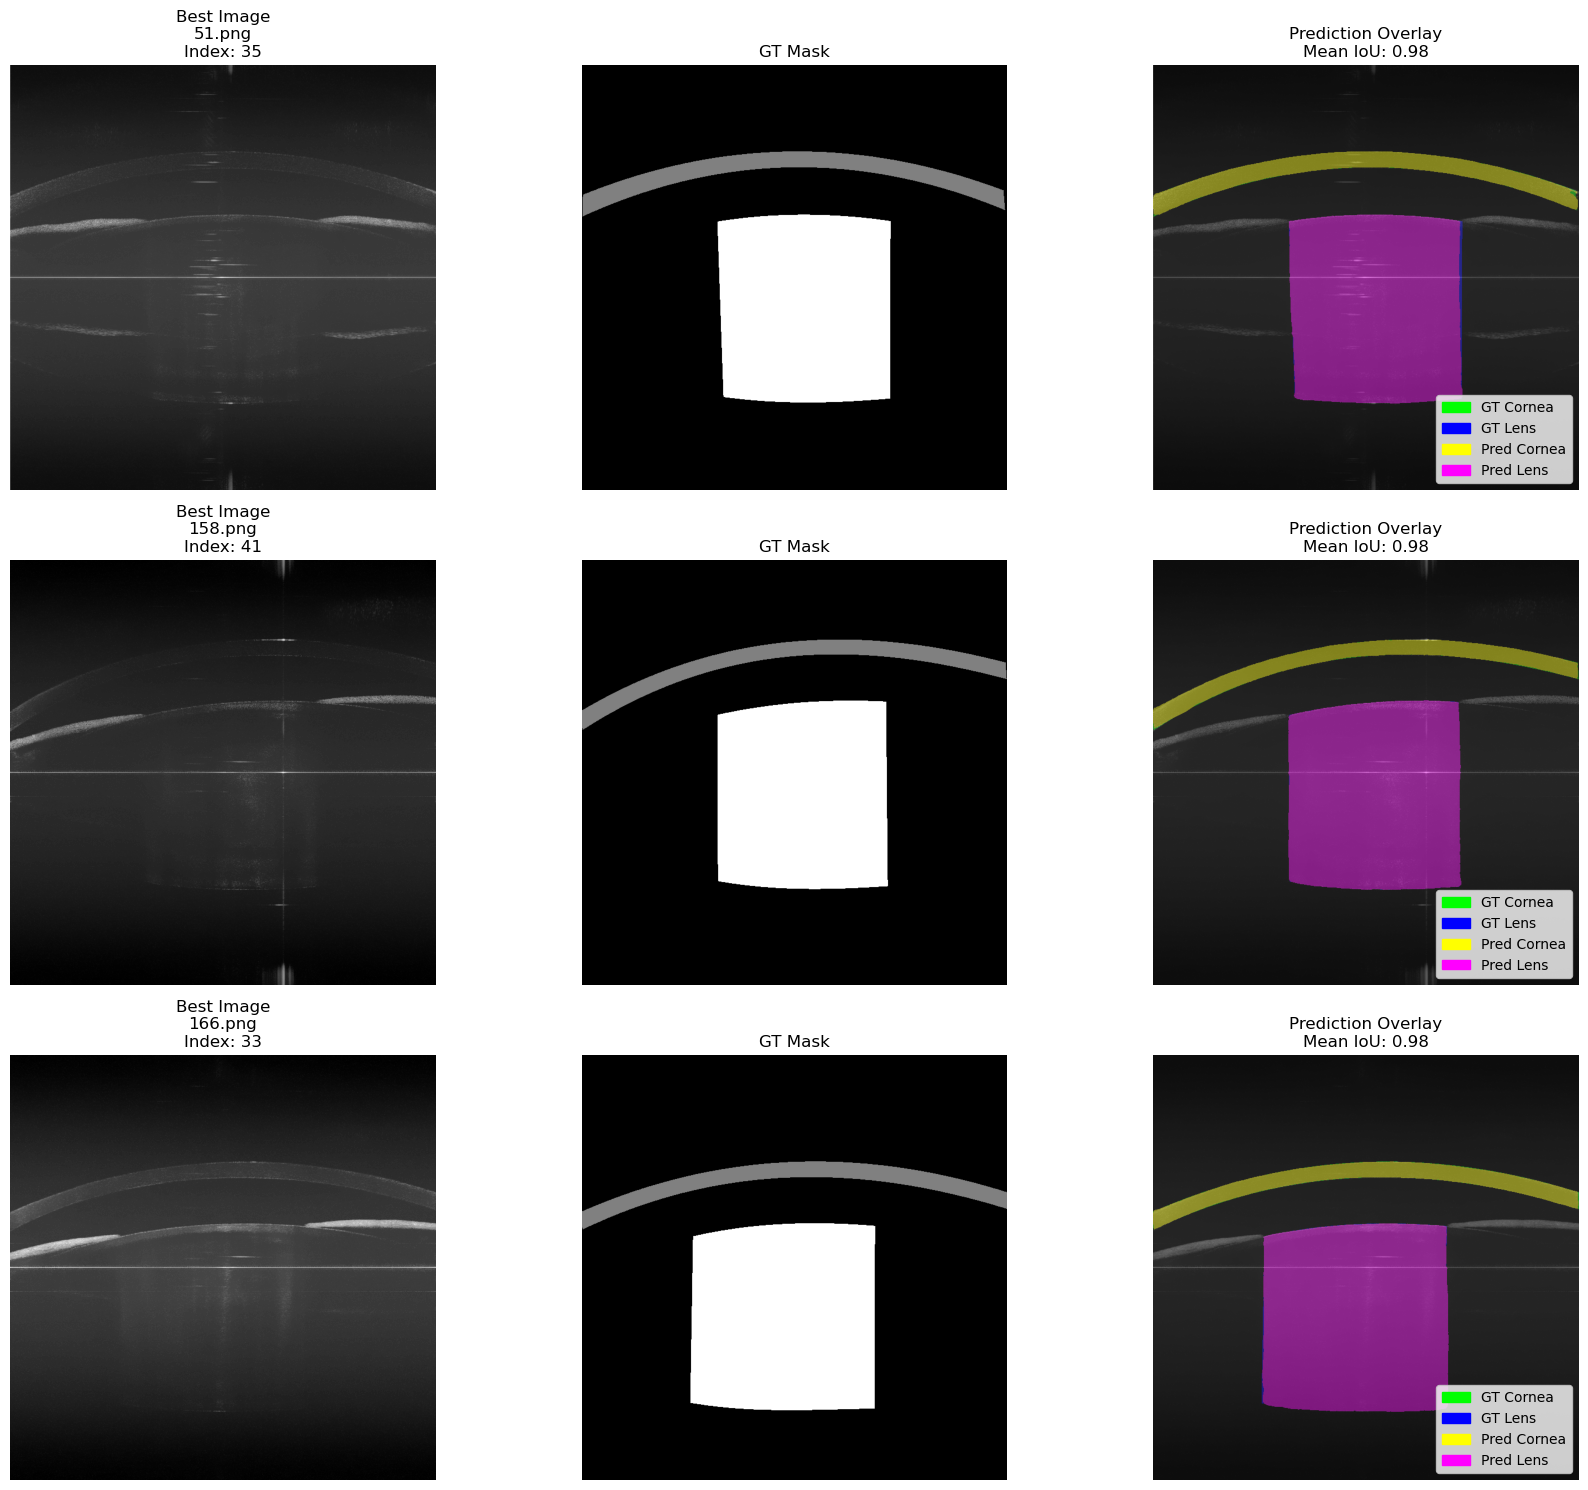

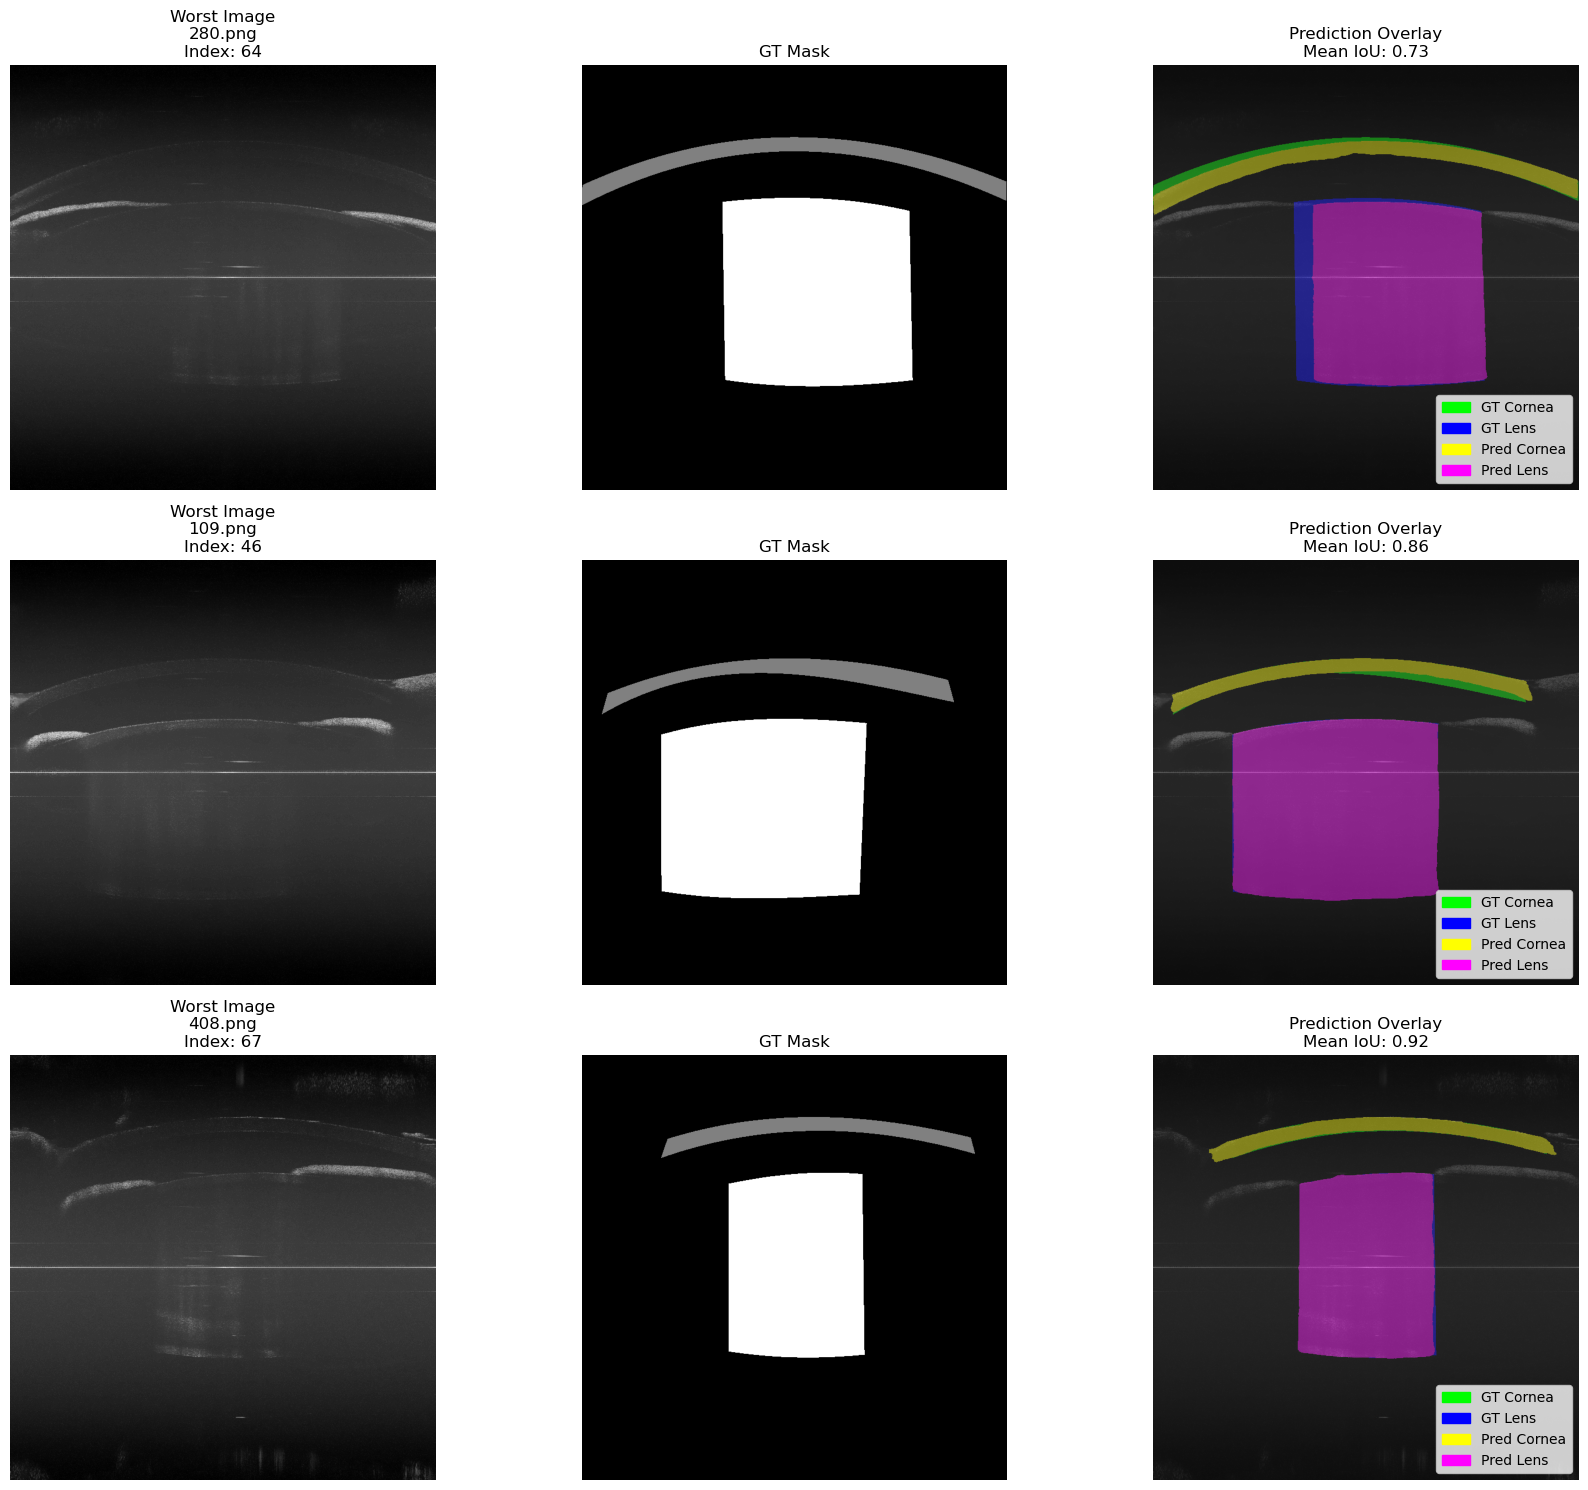


📊 Validation_Data Stats:
   Cornea IoU: 0.9278 ± 0.0489
   Lens   IoU: 0.9785 ± 0.0187


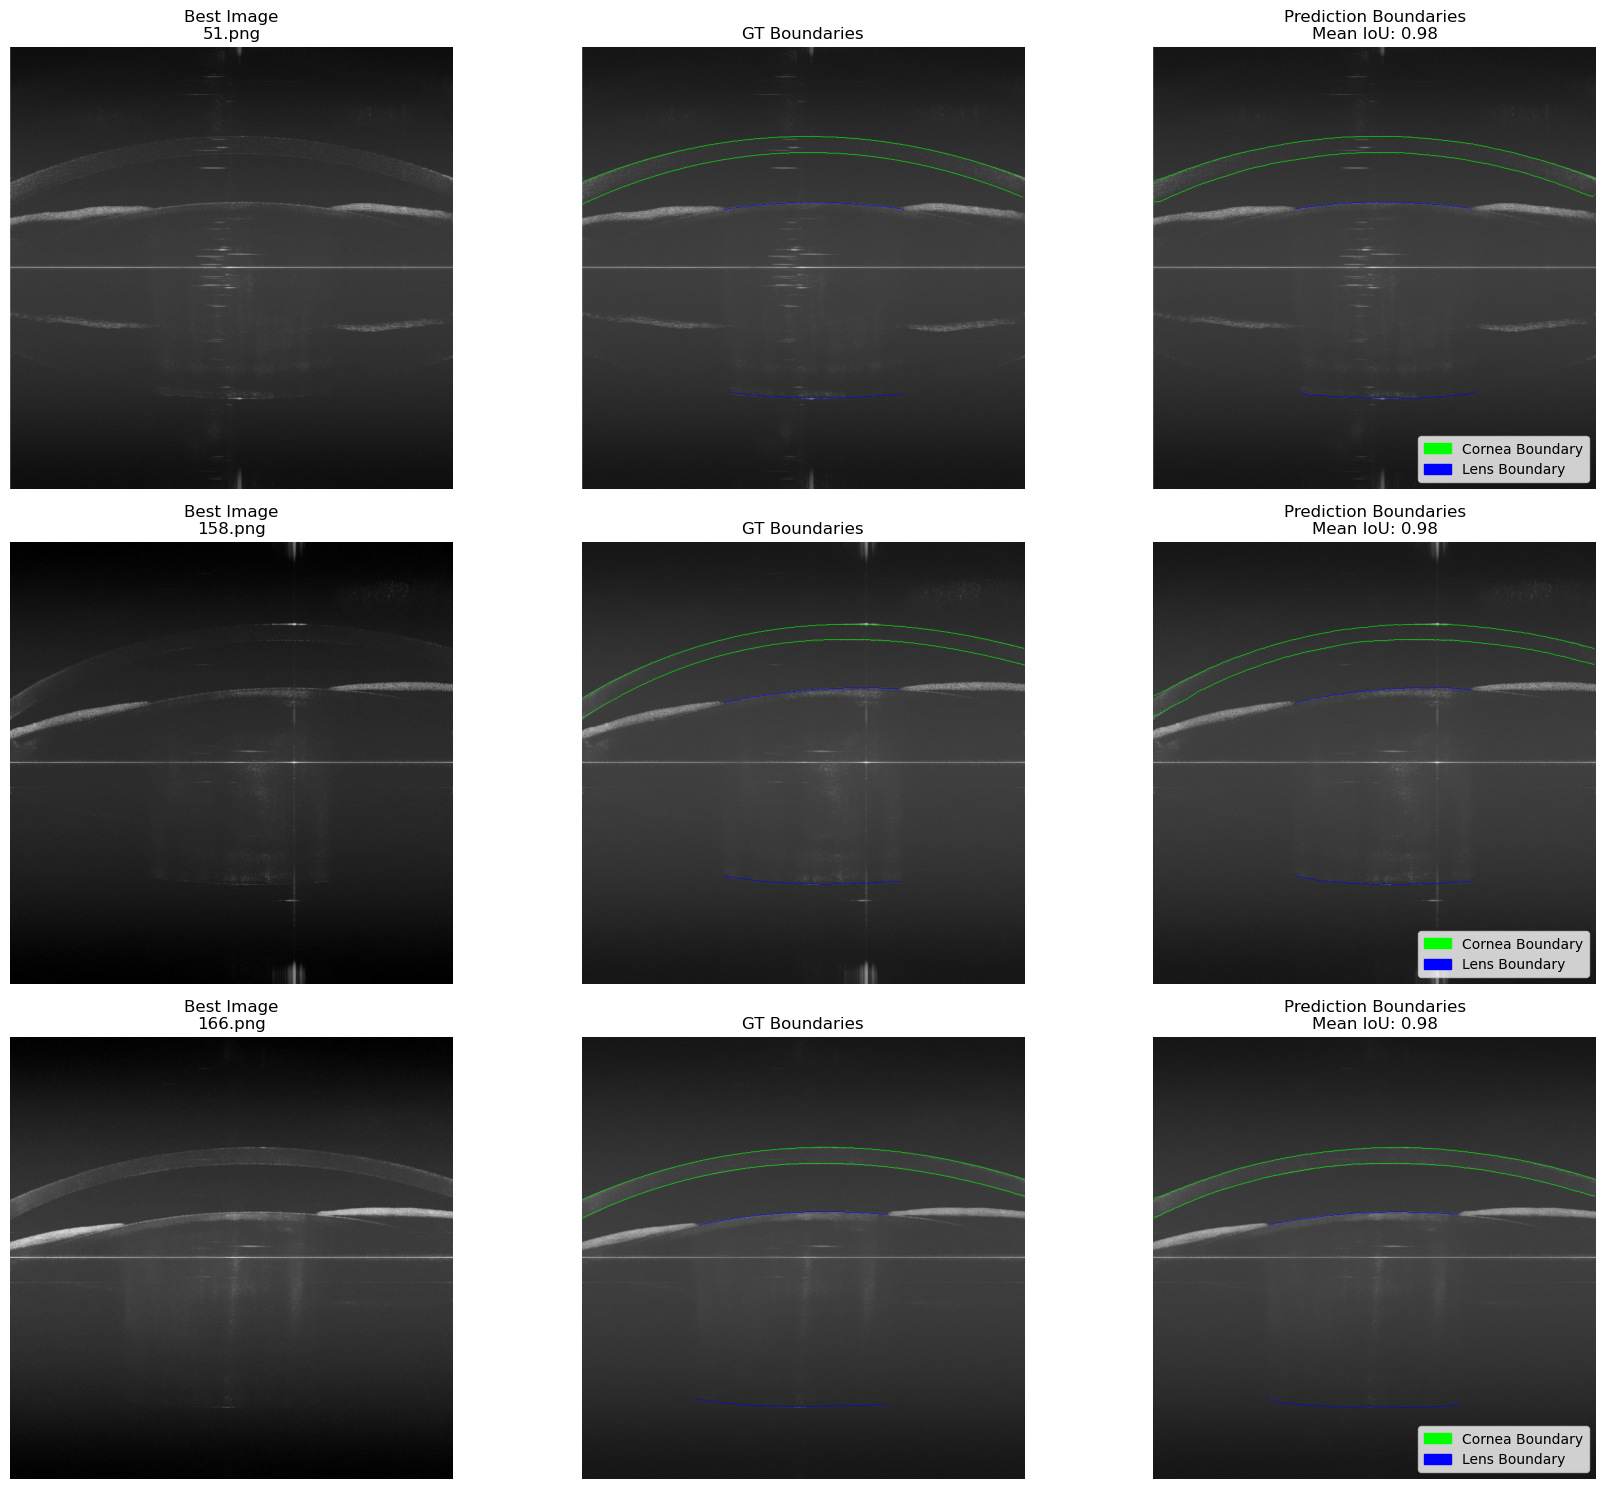

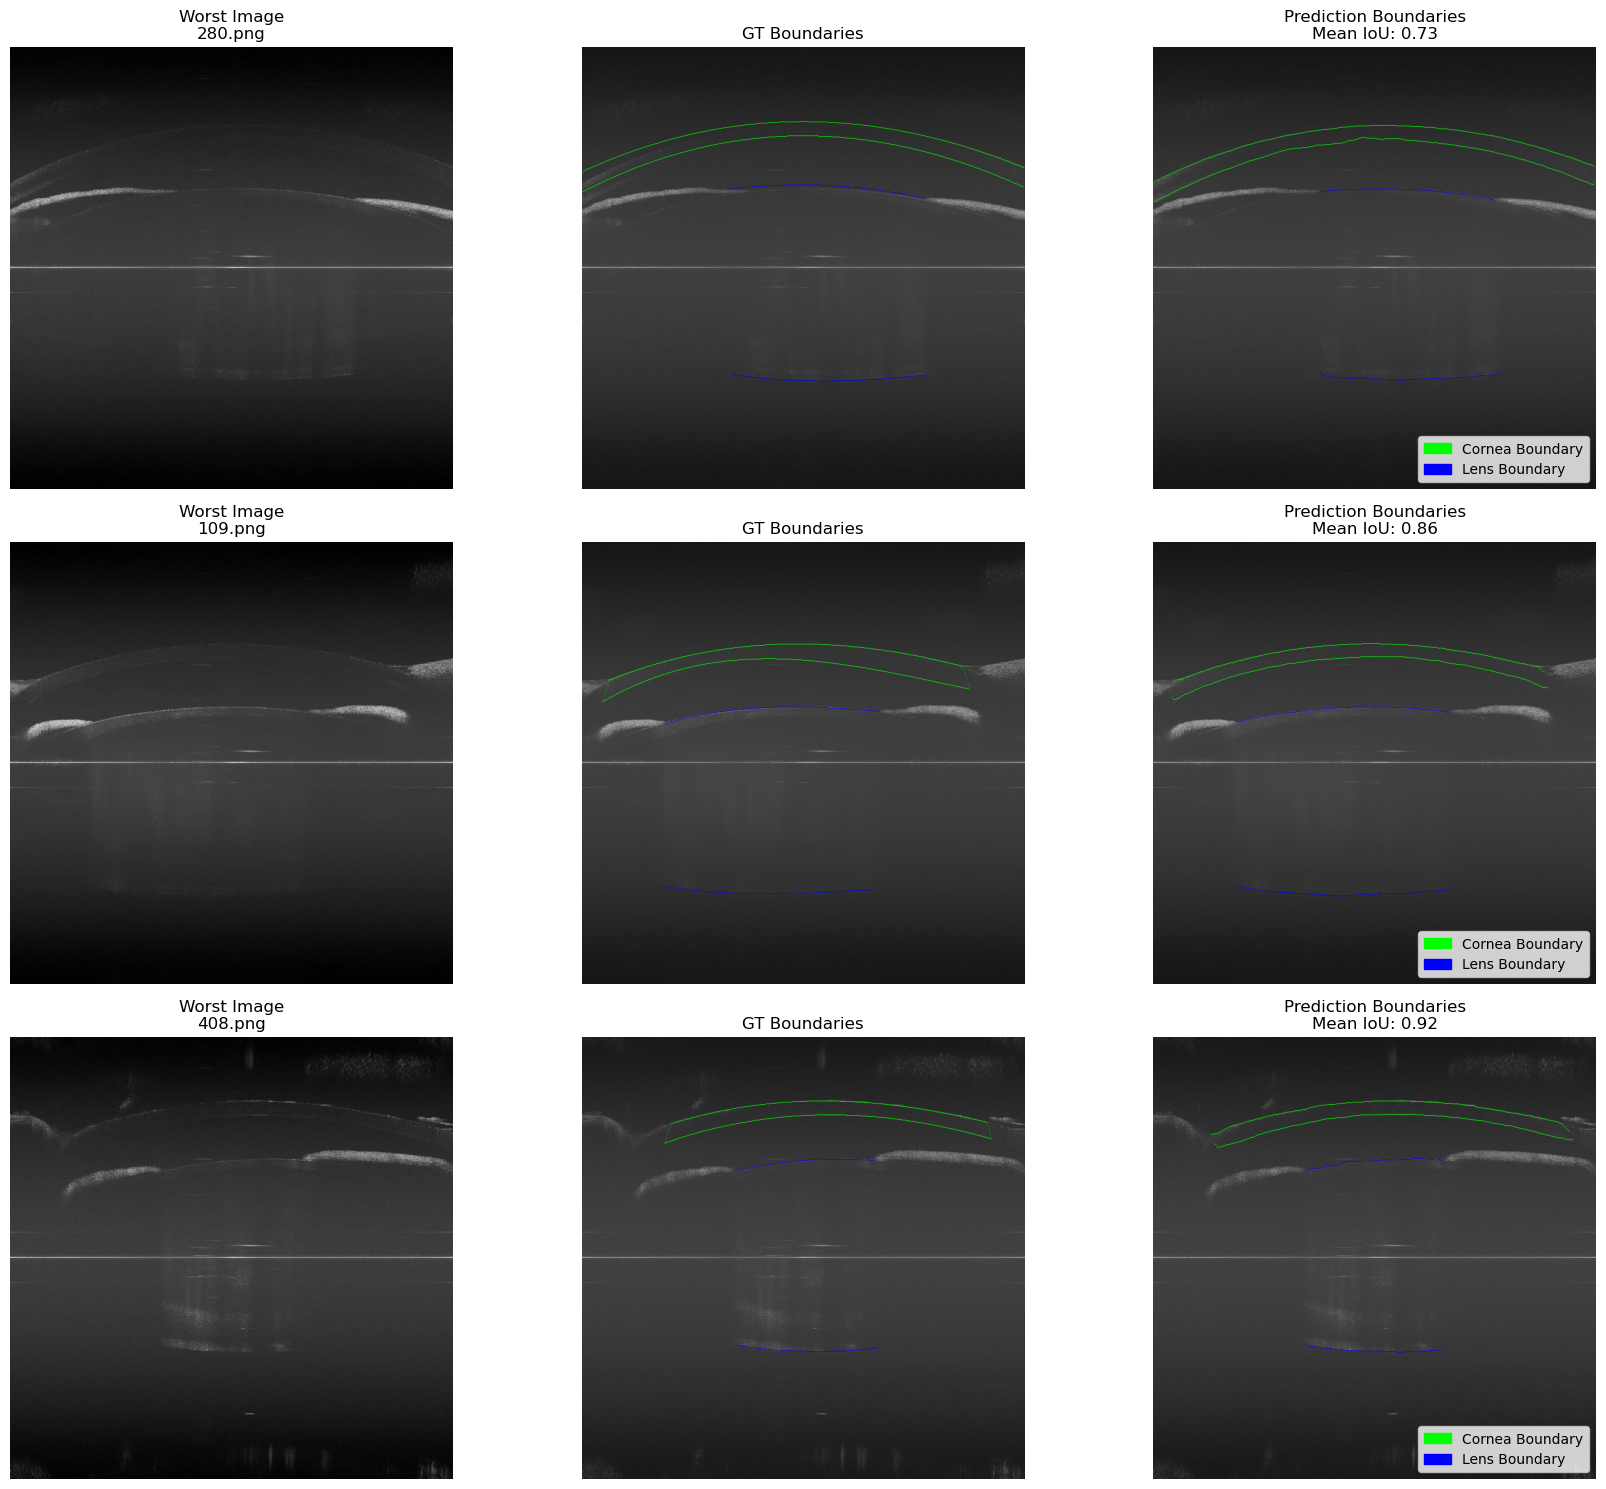


📊 Validation_Data Stats:
   Cornea IoU: 0.9278 ± 0.0489
   Lens   IoU: 0.9785 ± 0.0187
🔧 Fitting boundaries for: 51.png


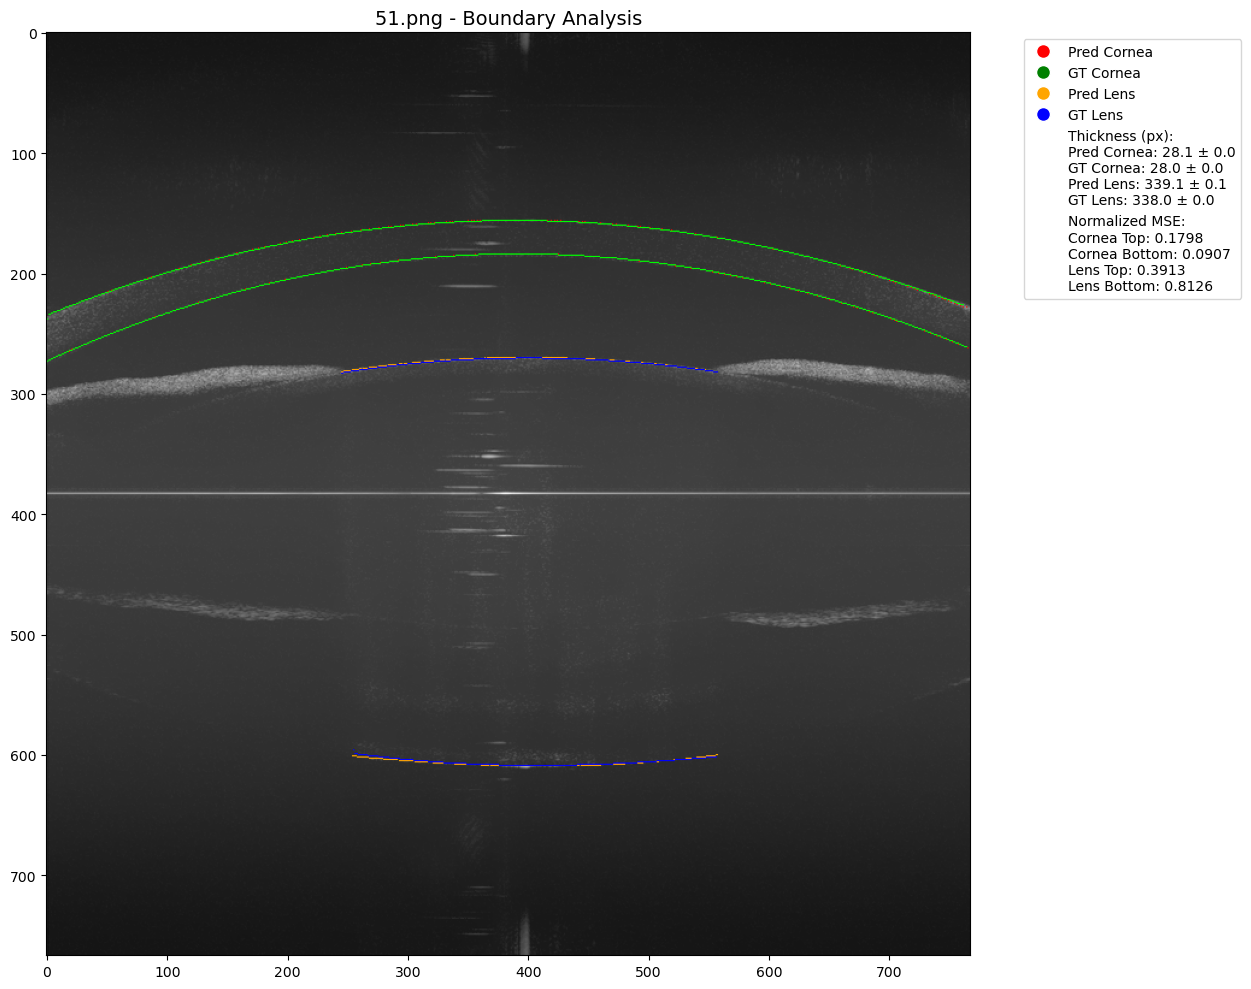

🔧 Fitting boundaries for: 158.png


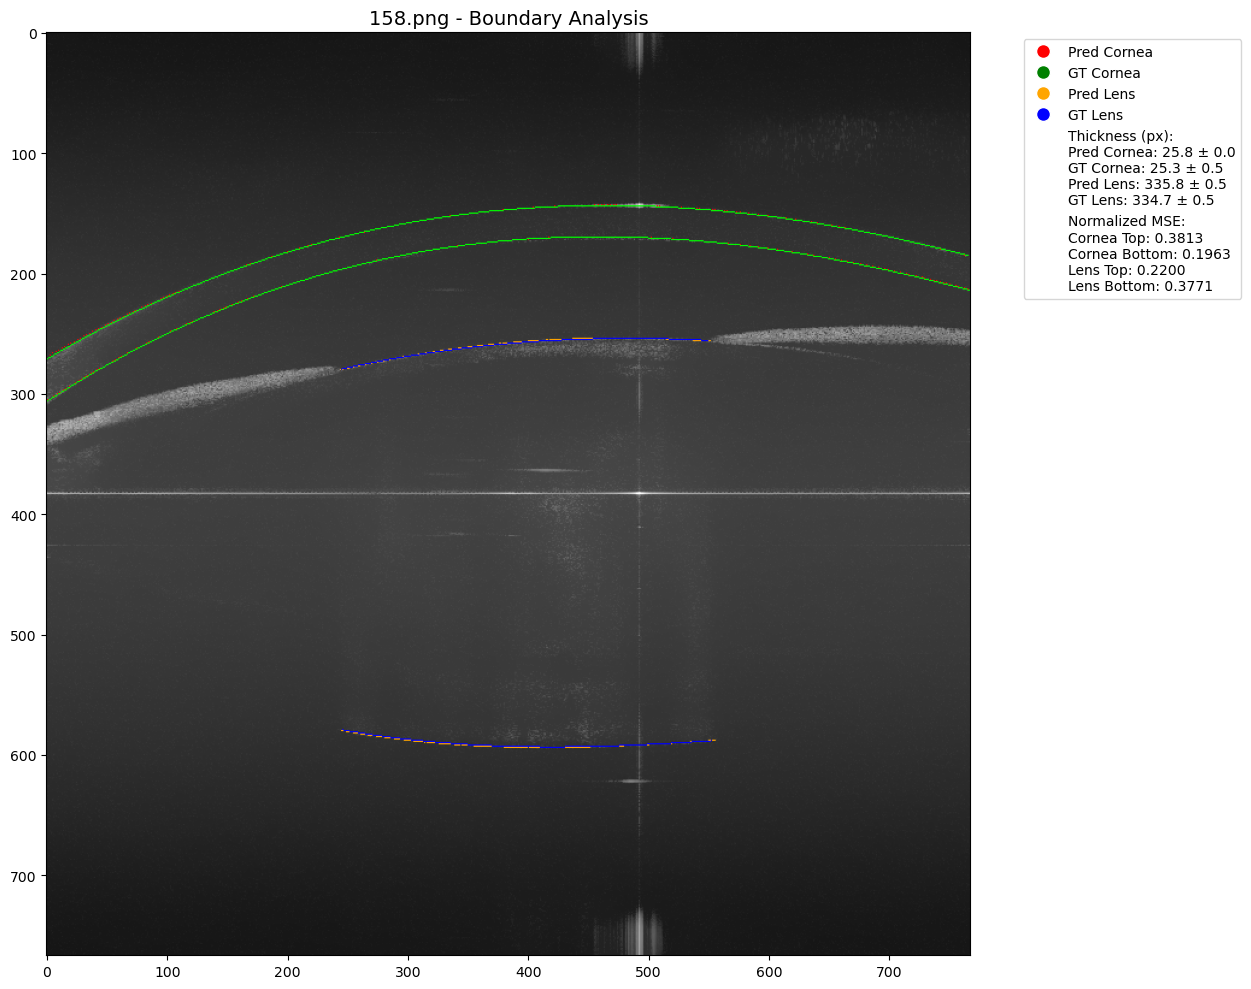

🔧 Fitting boundaries for: 166.png


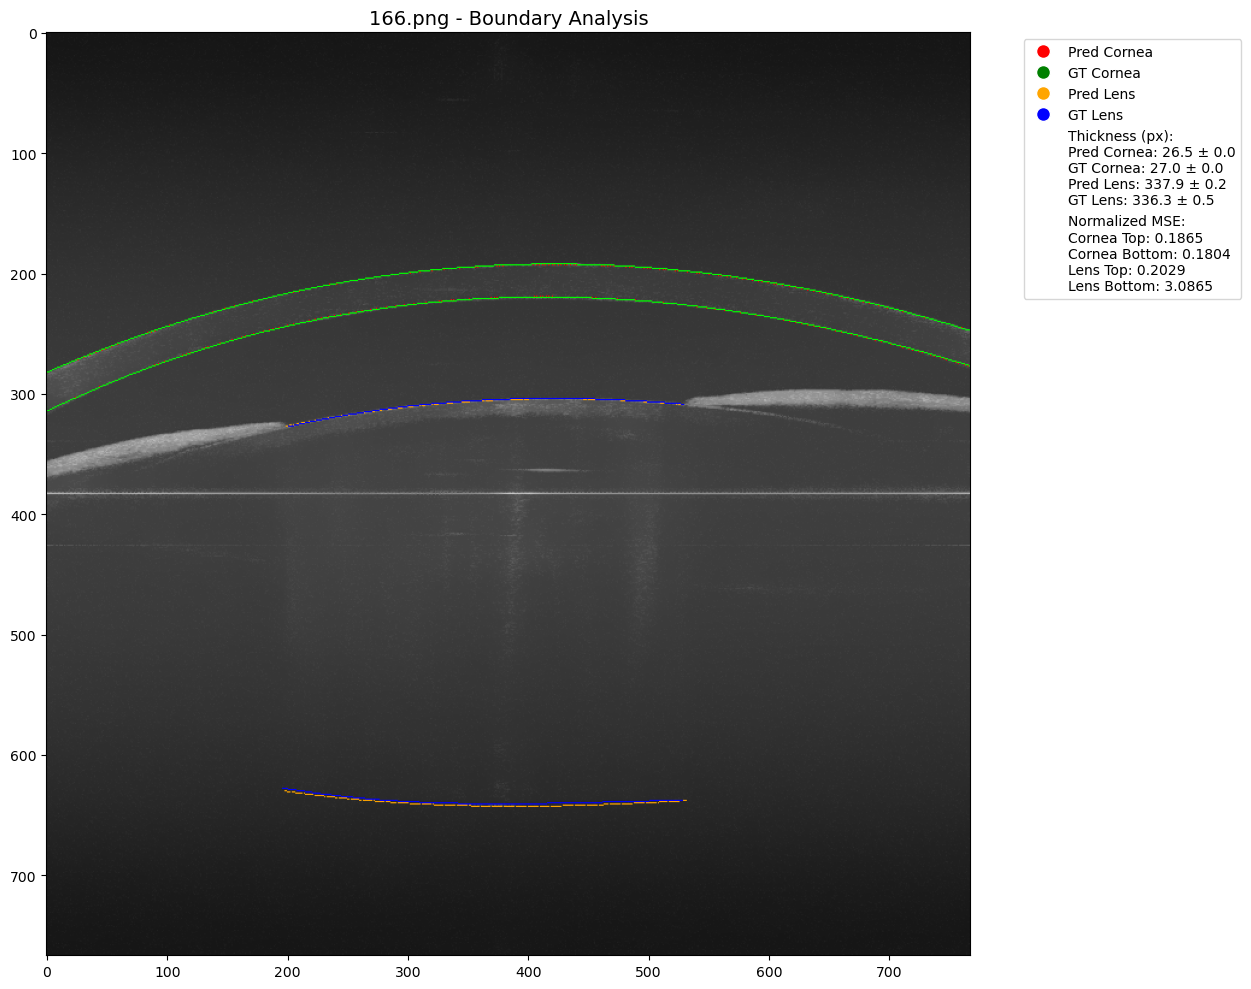

🔧 Fitting boundaries for: 280.png


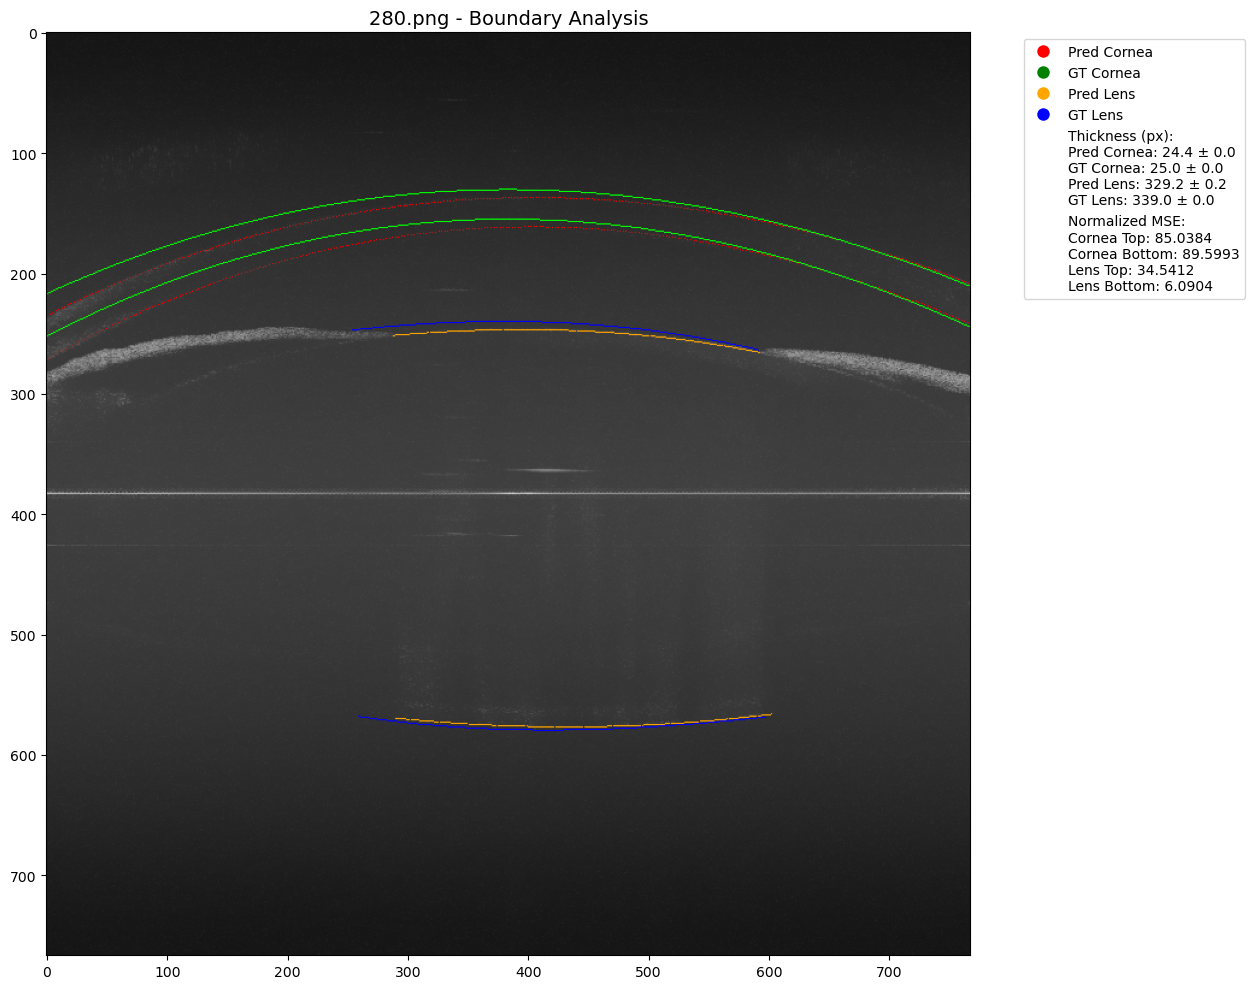

🔧 Fitting boundaries for: 109.png


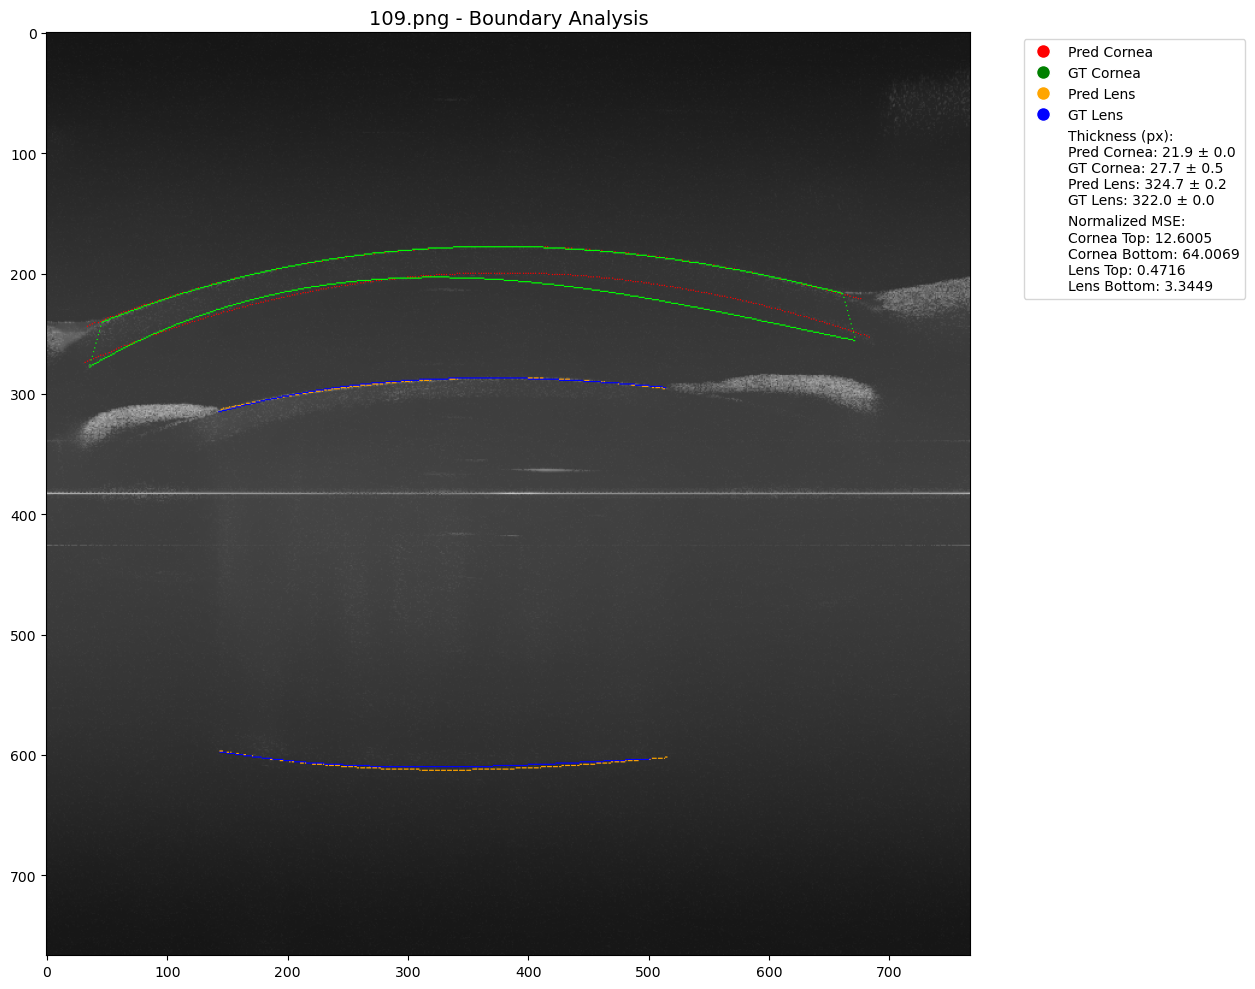

🔧 Fitting boundaries for: 408.png


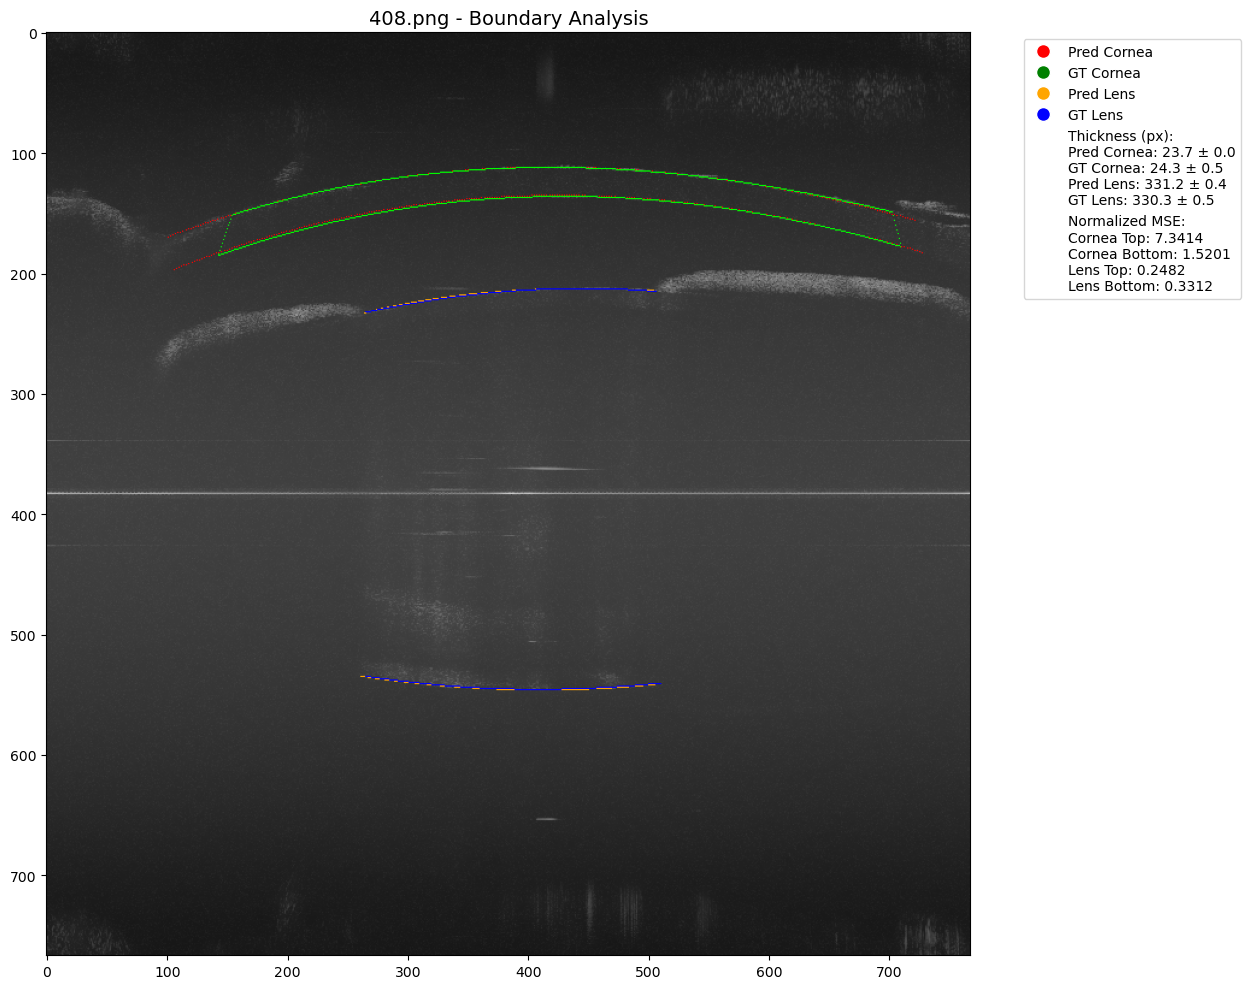

In [13]:
### Define The Data and Plots;
Data = val_dataset                       # Define the Data to show:
Model = model                            # Define the model:
Name = "Validation_Data"                 # Name the model:
maskless = False                         # If no masks, set to True, if masks set to False:
requested_indices = None # [1,2,3] #     # Plot best and worst, set to None, or give a list:

### Desired Plots
# Plot the area
AreaPlot = True
# Plot the detected edges
EdgePlot = True
# Plot The fitted Area
PlotFitEdge = True
show_individual_fits = True              # Plot intermediary plots:
show_final_overlay = True                # Show final plt:

# Run The Desired:
if AreaPlot == True:
    evaluate_subset(Data, Name, maskless = maskless, requested_indices = requested_indices)
if EdgePlot == True:
    evaluate_subset_with_boundaries(Model, Data, Name, image_dir, mask_dir, full_dataset, fit_boundaries = False, requested_indices = requested_indices)  
if PlotFitEdge == True:
    evaluate_subset_with_boundaries(Model, Data, Name, image_dir, mask_dir, full_dataset, fit_boundaries = True, requested_indices = requested_indices, show_individual_fits = show_individual_fits, show_final_overlay = show_final_overlay)

# Test Data:

In [1]:
# Define paths for Test data Image and (if available) Masks:
image_dir2 = None
mask_dir2  = None

if image_dir2 is not None:
    
    # Import the model;
    path_model = path_model # Or define here new ; "Model_Final_ALLRabbitEye1.pth"
    
    # Provide the path for the images (and masks, if any):
    if image_dir2 is not None:
        if mask_dir2 is not None:
            test_data = OCTFolderDataset(image_dir2, mask_dir2)
            print("✅ test images and masks loaded successfully.")
        else:
            test_data = OCTFolderDataset(image_dir2)
            print("✅ test images loaded successfully.")
    
    # Rebuild the model architecture
    if Load_Model is not None:
        model = model # Or define here manually --> = smp.Unet(encoder_name="timm-efficientnet-b2", encoder_weights="imagenet", classes=3, activation=None)
        model.load_state_dict(torch.load(path_model))
        model = model.to(device)
        model.eval()
        print("✅ Model loaded successfully.")

In [2]:
if image_dir2 is not None:

    ### Define The Data and Plots;
    Data = test_data                         # Define the Data to show:
    Name = "Test_Data"                       # Name the model:
    if mask_dir2 is None:
        maskless = True
    else:
        maskless = False
    requested_indices =  [1,2,3] # None      # Plot best and worst, set to None, or give a list:
    
    ### Desired Plots
    # Plot the area
    AreaPlot = True
    # Plot the detected edges
    EdgePlot = True
    # Plot The fitted Area
    PlotFitEdge = True
    show_individual_fits = True              # Plot intermediary plots:
    show_final_overlay = True                # Show final plt:
    
    # Run The Desired:
    if AreaPlot == True:
        evaluate_subset(Data, Name, maskless = maskless, requested_indices = requested_indices)
    if EdgePlot == True:
        evaluate_subset_with_boundaries(model, Data, Name, image_dir2, mask_dir2,  Data, fit_boundaries = False, requested_indices = requested_indices)  
    if PlotFitEdge == True:
        evaluate_subset_with_boundaries(model, Data, Name, image_dir2, mask_dir2,  Data, fit_boundaries = True, requested_indices = requested_indices, show_individual_fits = show_individual_fits, show_final_overlay = show_final_overlay)